In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

import numpy as np
from matplotlib import pyplot as plt

# Convolutional Neural Network
## CIFAR-10 Image Classification
### 1. Loading the dataset

In [2]:
torch.manual_seed(0)

transform=transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
# transforms.ToTensor() --> convert the images from PIL to Tensor
# transforms.Normalize((mean_R, mean_G, mean_B), (SD_R, SD_G, SD_B)) --> normalize the image tensors
#                                                                        subtracts the mean & divides by SD for each channel
#                                                                           from each pixel value, subtract 0.5 (mean)
#                                                                           (need to get the mean from the training examples) 
#                                                                           and divide it by 0.5 
#                                                                           (dividing because SD of all pixels should sum to 1)
# the transforma function automatically does it -- pixel vals between -1 and 1 & SD = 1

trainset = datasets.CIFAR10(
    root='~/Downloads/',
    train=True,
    download=True,
    transform=transform
)

testset = datasets.CIFAR10(
    root='~/Downloads/',
    train=False,
    download=True,
    transform=transform
)

batchsize = 64
trainloader = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testloader = DataLoader(testset, batch_size=batchsize, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainset[0]             # returns X (image) and Y (label)
trainset[0][0]          # image is contained at index 0
trainset.classes        # returns a list of all classes
trainset[0][0].shape    # size of the image is 3 x 32 x 32 (in PyTorch, depth is first), but you need to reshape if you want to view it using plt
                        # instead of all this, we'll use a transformation -- normalize image but with -1 instead for the mean and 2 for SD
                        # this will give us back the original image (see next cell)

torch.Size([3, 32, 32])

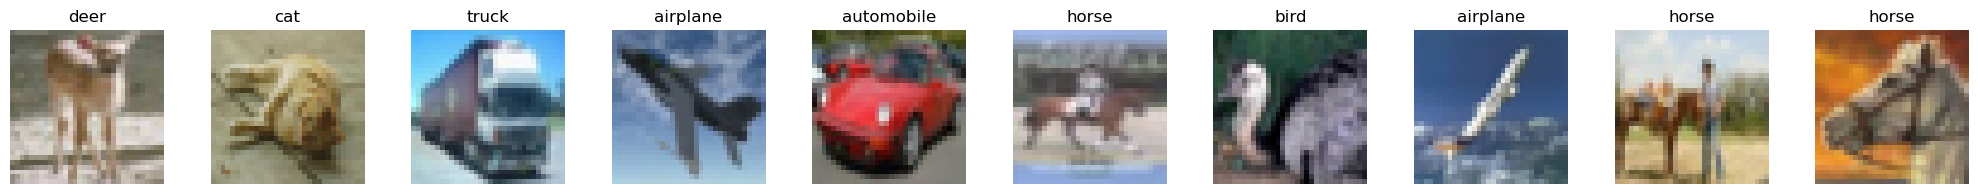

In [4]:
transform_back = transforms.Compose([transforms.Normalize((-1.,-1.,-1.), (2.,2.,2.)), 
                            transforms.ToPILImage()])       # revert the normalization 
                                                            # PIL takes care of changing the shape and the visualization
                                                            # without this parameter, shape will be 3 x 32 x 32; matplotlib expects 32 x 32 x 3
images, labels =  next(iter(trainloader))

idx_to_class = {value: key for key, value in trainset.class_to_idx.items()}     # creates a dictionary, key = class index, value = class label
# trainset.class_to_idx                                                         # gives you a dictionary, key = class label, value = class index

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))   # displays the image at index i after applying transform_back 
                                            # transform_back --> used to revert the normalization and convert the tensor back to PIL
    plt.axis('off')
    plt.title(idx_to_class[labels[i].item()])
plt.show()

### 2. Build a convolutional neural network (CNN) for classification

In [8]:
#device = torch.device('mps')                                                
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')     # you'll need to send everything to the 'device'  

class MyFirstCnnModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=4, kernel_size=3, stride=1, padding=1),   # input: 3 x 32 x 32
                                                                                            # 4 filters of size 3 x 3
                                                                                            # output: 4 x 32 x 32
            nn.ReLU(),
            
            nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=1),   # output: 8 x 32 x32
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=4, stride=4),                                          # output: 8 x 8 x 8

            nn.Flatten(),                                                                   # flatten it into one vector
            nn.Linear(8*8*8, 128),                                                         
            nn.ReLU(),
            nn.Linear(128, 10)                                                              # 10 --> 10 classes
                                                                                            # 2 fully-connected layers (the 2 nn.Linears)
            # nn.LogSoftmax(dim = 1)                                                        # only needed if you use NLLLoss function
                                                                                            # if you use CrossEntropy loss, no need
        )

        # it's better to use nn.Sequential rather than defining each layer separately and then applying forward() to each layer
        # here, we're just defining a network and then passing that to the forward function
          
    def forward(self, x):        
        return self.network(x)

In [9]:
model = MyFirstCnnModel()
model.to(device)
print(model)

MyFirstCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=512, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)


### 3. Train the network 

In [10]:
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
train_history = []                                         # both the training and validation loss should decrease with each epoch
val_history = []

In [11]:
# Training loop
model.train()                               # tell the model that your are training it
                                            # or you can also do model.eval() instead?
for epoch in range(10):                     # feeding 64 images in batch at each epoch
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()  
        outputs = model(inputs)
        
        loss = criteria(outputs, labels)
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()

    # validation
    with torch.no_grad():                       # temporarily disables gradient calc to save memory
        val_loss = 0
        for data in testloader:                 # iterate over batches of validation data (do the same as the training)
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criteria(outputs, labels)
            val_loss += loss.item()
            
    print(f'Epoch [{epoch}], train loss: {train_loss/len(trainset)}, val loss: {val_loss/len(testset)}')        
    train_history += [train_loss/len(trainset)]
    val_history += [val_loss/len(testset)]
print("Finished Training")

Epoch [0], train loss: 0.0256464666390419, val loss: 0.021861576533317564
Epoch [1], train loss: 0.02062661023259163, val loss: 0.019751132053136826
Epoch [2], train loss: 0.018853680477142334, val loss: 0.018739722937345504
Epoch [3], train loss: 0.01785379037618637, val loss: 0.018005898225307463
Epoch [4], train loss: 0.016938671606779098, val loss: 0.01779209479689598
Epoch [5], train loss: 0.016223895748853683, val loss: 0.017484376311302185
Epoch [6], train loss: 0.01557026820898056, val loss: 0.016755728018283844
Epoch [7], train loss: 0.015071123218536377, val loss: 0.016255166733264922
Epoch [8], train loss: 0.014610489425659179, val loss: 0.016503605967760085
Epoch [9], train loss: 0.0141578262424469, val loss: 0.0162473224401474
Finished Training


### 4. Plot Convergence plot

C:\Users\user\AppData\Local\Temp\ipykernel_31600\1543011309.py:7: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train loss', 'val loss')


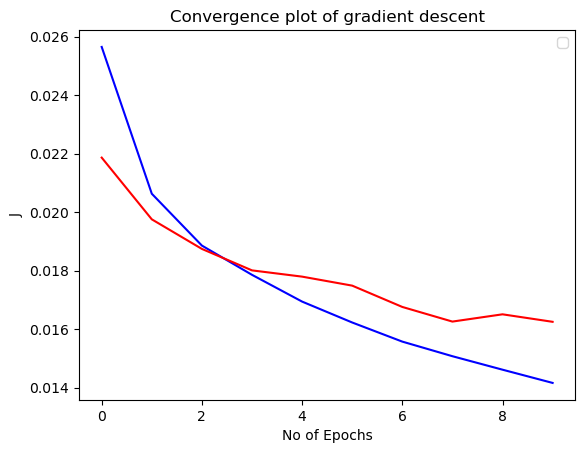

In [12]:
from matplotlib import pyplot as plt
plt.plot(train_history, 'b')
plt.plot(val_history, 'r')
plt.title('Convergence plot of gradient descent')
plt.xlabel('No of Epochs')
plt.ylabel('J')
plt.legend('train loss', 'val loss')
plt.show()

### 5. Validate on test set

Actual dog	Predicted: dog
Actual dog	Predicted: dog
Actual airplane	Predicted: airplane
Actual bird	Predicted: bird
Actual horse	Predicted: horse
Actual ship	Predicted: bird
Actual horse	Predicted: deer
Actual horse	Predicted: horse
Actual automobile	Predicted: automobile
Actual airplane	Predicted: deer


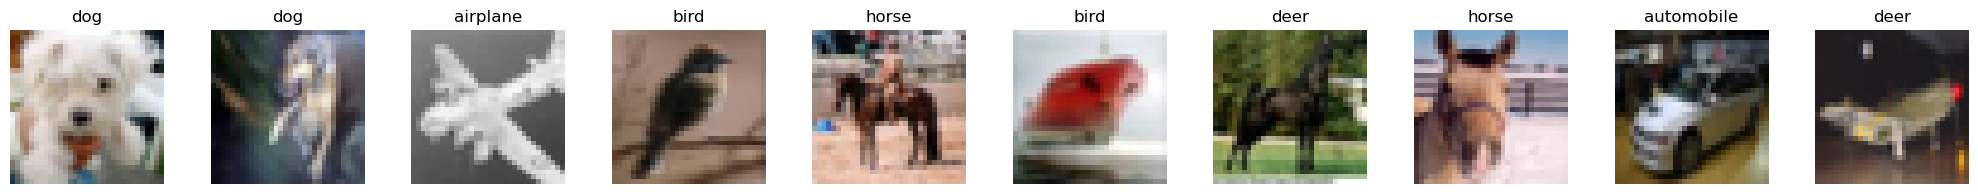

In [13]:
import torchvision

images, labels = next(iter(testloader))
images = images.to(device)
labels = labels.to(device)
    
outputs = model(images)
_, predicted = torch.max(outputs, 1)        # computes the predicted labels by finding the class index with the highest score for each image
                                            # torch.max() vs. torch.argmax()
                                            #   torch.max() --> returns the maximum value & its index
                                            #   torch.argmax() --> only returns the index of the max value

plt.figure(figsize=(20,30))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.tight_layout()
    plt.imshow(transform_back(images[i]))
    plt.axis('off')
    plt.title(idx_to_class[predicted[i].item()])
    print(f"Actual {idx_to_class[labels[i].item()]}\tPredicted: {idx_to_class[predicted[i].item()]}")
plt.show()

In [14]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total} %%')

Accuracy of the network on the 10000 test images: 63.86 %%
